In [7]:
import matplotlib.pyplot as plt

import lstm

SEQ_LEN=15

In [2]:
# get Microsoft's stock opening prices and create list of 15 day frames
times = lstm.get_time_series_daily("AAPL", filters=["1. open"], outputsize="full")
# times = lstm.get_time_series_daily("MSFT", filters=["4. close", "5. volume"], outputsize="full")
# times are returned descending from most recent so should be reversed
vectors = lstm.times_to_vectors(times)[::-1]
frames = lstm.get_frames(vectors, seq_len=SEQ_LEN, with_target=True) # each frame is 15+1 (trend length + prediction target) vectors

print(f"last frame: {frames[-1]}")
print(f"last target frame: {frames[-1][-1]}")

last frame: [['188.3500'], ['186.2300'], ['190.0200'], ['195.3400'], ['191.5100'], ['191.6640'], ['188.7500'], ['188.9500'], ['189.8300'], ['191.6400'], ['191.0900'], ['193.2500'], ['194.7900'], ['196.4500'], ['196.4200'], ['200.3200']]
last target frame: ['200.3200']


In [3]:
# seperate normalized frames into training and testing data
train, test = lstm.partition_data(frames, partition_coefficient=0.8)
# split training and testing data into sequences and their targets
train_x, train_y = lstm.seperate_xy(lstm.normalize_frames(train))
# train_y = [[target[0]] for target in train_y]

test_x, test_y = lstm.seperate_xy(lstm.normalize_frames(test))
# test_y = [[target[0]] for target in test_y]

print(f"training sequence 1: {train_x[0]}, target: {train_y[0]}")
print(f"testing sequence 1: {test_x[0]}, target: {test_y[0]}")

training sequence 1: [[0.0], [0.01979695431472095], [-0.015736040609137025], [-0.029441624365482144], [-0.0619289340101522], [-0.048223350253807085], [-0.029441624365482144], [-0.021827411167512634], [-0.03502538071065975], [-0.002538071065989911], [0.009644670050761528], [-0.03350253807106596], [-0.01878172588832494], [-0.022335025380710527], [-0.03756345177664966]], target: [-0.03350253807106596]
testing sequence 1: [[0.0], [0.003486189326897371], [0.002592294627692837], [0.012156967909180194], [0.006346652364351391], [0.002055957808170028], [0.017162778224725228], [0.015821936175918427], [0.00849199964244196], [-0.0042906945561813625], [-0.03200143023151869], [-0.047644587467596256], [-0.04174488245284702], [-0.02359882005899705], [0.007151157593635382]], target: [0.006525431304192253]


In [4]:
# create LSTM model using the training data
model = lstm.setup_lstm_model(train_x, train_y)
print(model)

compilation time :  0.025709867477416992
Train on 4054 samples, validate on 214 samples
Epoch 1/1
4054/4054 [==============================] - 2s 596us/step - loss: 0.0109 - val_loss: 0.0055


In [5]:
# predict results using the test data
predictions = lstm.predict_sequences_multiple(model, test_x)

final sequence: [[0.0], [-0.01125564109370858], [0.008866471993628888], [0.03711176002123717], [0.01677727634722581], [0.017594903105919713], [0.00212370586673738], [0.0031855588001061808], [0.007857711706928727], [0.017467480753915465], [0.014547385187151596], [0.026015396867533847], [0.03419166445447308], [0.04300504380143355], [0.042845765861428076]]
predicted: [0.00599163]
actual: [0.06355189806211836]


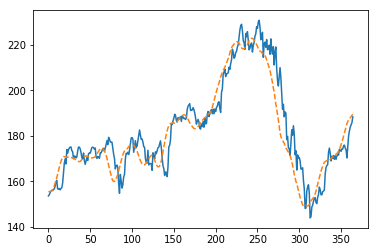

Next predicted normalized value:
current: 200.3200
next predicted: 190.2867392931506


In [9]:
print(f"final sequence: {test_x[-1]}")
print(f"predicted: {predictions[-1]}")
print(f"actual: {test_y[-1]}")
# plot the results of the last month
# (dashed line is prediction)
def plot_results_multiple(predicted_data, frames):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)

    targets = [float(frame[0][0]) for frame in frames]
    denormalized_predictions = [
        lstm.denormalize_dim(prediction[0], targets[i])
        for i, prediction in enumerate(predicted_data)
    ]

    ax.plot(targets, label="Actual")

    plt.plot(
        denormalized_predictions,
        label="Predicted",
        linestyle="dashed"
    )

    plt.show()

plot_results_multiple(predictions[-365:], test[-365:])

# get next prediction:
next_seq = frames[-1][-SEQ_LEN:]
current_val = next_seq[-1]
next_predicted = lstm.predict_sequences_multiple(model, [lstm.normalize_frame(next_seq)])
print("Next predicted normalized value:")
print(f"current: {current_val[0]}")
print(f"next predicted: {lstm.denormalize_dim(next_predicted[0][0], next_seq[0][0])}")